In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import os
import numpy as np
from catboost import CatBoostClassifier, Pool,CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,mean_squared_error,r2_score
from sklearn.multioutput import MultiOutputRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

current_path = os.getcwd()
root_path = os.path.dirname(current_path)
root_path = os.path.dirname(root_path)
root_path = '/content/gdrive/Othercomputers/My Computer/Fire_risk_main/Fire_risk_main/data/Fire-data-paper-hongru_share/'
data_path= root_path + '/github_repo/data/'





In [5]:
import sys
print(sys.version)

!pip show catboost

!pip show scikit-learn

3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Name: catboost
Version: 1.2.8
Summary: CatBoost Python Package
Home-page: https://catboost.ai
Author: CatBoost Developers
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: graphviz, matplotlib, numpy, pandas, plotly, scipy, six
Required-by: 
Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of co

In [6]:
package_versions = {
    'pandas': pd.__version__,
    'os': 'builtin',
    'numpy': np.__version__,
    #'catboost': catboost.__version__,
    #'scikit-learn': sklearn.__version__,
    #'matplotlib': matplotlib.__version__,
    'seaborn': sns.__version__,
    'joblib': joblib.__version__
}

package_versions

{'pandas': '2.2.2',
 'os': 'builtin',
 'numpy': '2.0.2',
 'seaborn': '0.13.2',
 'joblib': '1.5.1'}

In [7]:
df=pd.read_pickle(data_path + '/step2_consequence_injury_severity.pkl')
df_new2=pd.read_pickle(data_path + '/raw_data_with_city_info.pkl')


In [8]:
cpi_map={'2012':1,
         '2013':1.02,
         '2014':1.02,
         '2015':1.03,
         '2016':1.05,
         '2017':1.07,
         '2018':1.09,
         '2019':1.12,
         '2020':1.13,
         '2021':1.21,
         '2022':1.29
}
df['median_income_list'] = df.apply(lambda row: row['median_income_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)
df['median_rent_list'] = df.apply(lambda row: row['median_rent_list'] / cpi_map.get(row['accident_year'], 1)*1.29, axis=1)


In [9]:
df=df[df['CAUSE_IGN']!='0']
df=df[df['HEAT_SOURCE_new']!='6']
df=df[df['FACT_IGN1_new']!='7']
df=df[df['AREA_ORIG_new']!='8']
df=df[df['AREA_ORIG_new']!='9']

def remove_outliers_z(df, columns, threshold=3):
    for col in columns:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df = df[(z_scores < threshold) & (z_scores > -threshold)]
    return df

df = df[(df['last_unit_clear_time'] < 600)&(df['TOT_SQ_FT'] < 50000)].reset_index().drop(columns = ['index'])


In [11]:
columns_drop=['DET_OPERAT','build_time_1939_and_earlier_list','build_time_1940_to_1979_list','total_population_list','SUP_APP', 'EMS_APP', 'OTH_APP','Pct_GRAPI_35_pct_or_more_list',
       'Pct_GRAPI_Less_than_15_pct_list','Pct_EDU_Less_than_9th_grade_list',
       'SUP_PER', 'EMS_PER', 'OTH_PER','AID']
df.drop(columns=columns_drop,inplace=True)

In [13]:
object_columns = df.select_dtypes(include=['object']).columns
print("Object columns:")
print(object_columns)

# Print float columns
float_columns = df.select_dtypes(include=['float','int']).columns
print("Float columns:")
print(float_columns)

Object columns:
Index(['STATE', 'CAUSE_IGN', 'FIRE_SPRD', 'FLAME_SPRD', 'DETECTOR', 'AES_PRES',
       'INCIDENT_KEY', 'accident_year', 'accident_month', 'accident_day',
       'accident_hour', 'hum_1', 'AREA_ORIG_new', 'ACT_TAK1_new',
       'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new', 'TYPE_MAT_new',
       'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new', 'MAT_SPRD_new'],
      dtype='object')
Float columns:
Index(['NUM_UNIT', 'BLDG_ABOVE', 'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG',
       'response_time', 'last_unit_clear_time', 'median_income_list',
       'median_rent_list', 'Pct_HOU_Occupied_units_list',
       'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
       'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
       'Pct_SA_62_and_over_list',
       'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
       'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'SEV_1',
       'SEV_2', 'SEV_3', 'SEV_4', 'SEV_5

In [14]:
df_new=df_new2[['INCIDENT_KEY', 'CBSA Code','CBSA Title','State_Abbrs', 'HHS_Region',
       'Census_Region', 'Census_Division']]
df_filtered=df.merge(df_new,on='INCIDENT_KEY',how='left').copy()

In [15]:
counts = df_filtered.groupby(['CBSA Title']).size().reset_index(name='count')

# Keep only those with count >= 2
valid_pairs = counts[counts['count'] >= 5][['CBSA Title','count']]

# Merge to filter the DataFrame
df_filtered = df_filtered.merge(valid_pairs, on=['CBSA Title'])
df_filtered.drop(columns=['count'],inplace=True)

In [ ]:
df_filtered.columns, df_filtered.shape

(Index(['STATE', 'NUM_UNIT', 'CAUSE_IGN', 'FIRE_SPRD', 'BLDG_ABOVE',
        'BLDG_BELOW', 'TOT_SQ_FT', 'FIRE_ORIG', 'FLAME_SPRD', 'DETECTOR',
        'AES_PRES', 'INCIDENT_KEY', 'response_time', 'last_unit_clear_time',
        'accident_year', 'accident_month', 'accident_day', 'accident_hour',
        'median_income_list', 'median_rent_list', 'Pct_HOU_Occupied_units_list',
        'Pct_HHF_Utility_gas_list', 'Pct_DIS_With_disability_list',
        'Pct_EDU_Bachelor_or_higher_list', 'Pct_HIC_With_coverage_list',
        'Pct_SA_62_and_over_list',
        'Pct_EMP_Pop_16_and_over_in_labor_force_Civilian_labor_force_Employed_list',
        'temp', 'rhum', 'wspd', 'Minority populations', 'Black Alone', 'hum_1',
        'SEV_1', 'SEV_2', 'SEV_3', 'SEV_4', 'SEV_5', 'AREA_ORIG_new',
        'ACT_TAK1_new', 'FACT_IGN1_new', 'HEAT_SOURCE_new', 'FIRST_IGN_new',
        'TYPE_MAT_new', 'PROP_USE_new', 'SUP_FAC_1_new', 'ITEM_SPRD_new',
        'MAT_SPRD_new', 'build_time_1980_to_later_list', 'sol

In [16]:
# category prediction

df_label = df_filtered.copy()
#vsl_proportion = [x * 1000 for x in [0.003, 0.047, 0.105, 0.266, 1]]
vsl_proportion = [x * 1000 for x in [0.003, 0.047, 0.266, 0.593, 1]]


#vsl_proportion = [1,4,9,16,25]


# Multiply each column by its corresponding value in vsl_proportion
df_label['vsl_proportion'] = (
    df_label['SEV_1'] * vsl_proportion[0] +
    df_label['SEV_2'] * vsl_proportion[1] +
    df_label['SEV_3'] * vsl_proportion[2] +
    df_label['SEV_4'] * vsl_proportion[3] +
    df_label['SEV_5'] * vsl_proportion[4]
)

#thresholds = df_label['vsl_proportion'].quantile([0.4, 0.6, 0.8])
thresholds = df_label['vsl_proportion'].quantile([0.4,0.8])

print(thresholds)
#bins = [-float('inf'), thresholds[0.25], thresholds[0.5], thresholds[0.75], float('inf')]
#bins = [-float('inf'), thresholds[0.5], thresholds[0.75], thresholds[0.9], float('inf')]
#bins = [0, thresholds[0.4],  thresholds[0.8], float('inf')]
#bins = [-float('inf'), 266,  1000, float('inf')]
bins = [0, 6,  593,float('inf')]

#labels = ['Low Risk', 'Moderate Risk', 'High Risk', 'Very High Risk']
labels = ['0', '1', '2']

# Assign risk groups based on the thresholds
df_label['Risk_Group'] = pd.cut(df_label['vsl_proportion'], bins=bins, labels=labels, include_lowest=True)

X = df_label.drop(columns=['SEV_1', 'SEV_2', 'SEV_3', 'SEV_4', 'SEV_5', 'vsl_proportion','FIRE_SPRD','Risk_Group','last_unit_clear_time',
                          'CBSA Title', 'State_Abbrs', 'HHS_Region',
        'Census_Region', 'Census_Division'])
y = df_label['Risk_Group']


X_train_list, X_test_list = [], []
y_train_list, y_test_list = [],[]

# Loop over each region
for region_name, group_df in X.groupby('CBSA Code'):
    y_group = y[group_df.index]  # align y with current group

    # Stratify on y within the group
    X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(
        group_df, y_group, test_size=0.3, random_state=2042
    )

    # Collect the splits
    X_train_list.append(X_train_group)
    X_test_list.append(X_test_group)
    y_train_list.append(y_train_group)
    y_test_list.append(y_test_group)

# Concatenate all regions
X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

X_train.drop(columns=['CBSA Code'], inplace=True)
X_test.drop(columns=['CBSA Code'], inplace=True)


categorical_features = [col for col in X_test.columns if X_test[col].dtype == 'object']


train_data = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_data = Pool(data=X_test, label=y_test, cat_features=categorical_features)



0.4       6.0
0.8    1000.0
Name: vsl_proportion, dtype: float64


In [17]:
y_train.value_counts(normalize=True)

,proportion
Risk_Group,
0,0.413765
1,0.367414
2,0.218821


In [18]:
# Initialize and train the CatBoost model (now using classification)
model = CatBoostClassifier(iterations=1500,
                            depth=4,
                          learning_rate=0.1,
                            l2_leaf_reg=6,
                          class_weights=[1,1,1],
                          task_type='GPU',
                          loss_function='MultiClass',
                            random_state=2042)
model.fit(train_data, verbose=100)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classification performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Classification Report:\n{report}')

0:	learn: 1.0751598	total: 35.4ms	remaining: 53.1s
100:	learn: 0.8939390	total: 2.4s	remaining: 33.3s
200:	learn: 0.8769558	total: 3.09s	remaining: 20s
300:	learn: 0.8655502	total: 3.69s	remaining: 14.7s
400:	learn: 0.8553240	total: 6.98s	remaining: 19.1s
500:	learn: 0.8451290	total: 10.7s	remaining: 21.2s
600:	learn: 0.8366246	total: 13.8s	remaining: 20.7s
700:	learn: 0.8287608	total: 16.4s	remaining: 18.7s
800:	learn: 0.8208158	total: 19.1s	remaining: 16.7s
900:	learn: 0.8118738	total: 21.5s	remaining: 14.3s
1000:	learn: 0.8038466	total: 22.8s	remaining: 11.4s
1100:	learn: 0.7967446	total: 23.5s	remaining: 8.53s
1200:	learn: 0.7889618	total: 24.8s	remaining: 6.17s
1300:	learn: 0.7821771	total: 26.2s	remaining: 4.01s
1400:	learn: 0.7747944	total: 29.6s	remaining: 2.09s
1499:	learn: 0.7678230	total: 30.2s	remaining: 0us
Accuracy: 0.55
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.74      0.65      4051
           1       0.

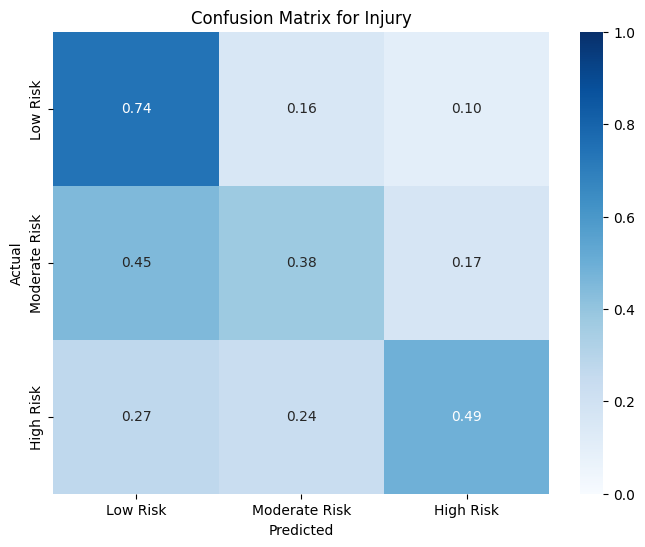

In [19]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix to 0-1 scale
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define the new labels
labels = ['Low Risk', 'Moderate Risk', 'High Risk']

# Plot the confusion matrix with a normalized color bar (0-1)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels, vmin=0, vmax=1)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Injury')
#plt.colorbar(label='Proportion')
plt.show()



In [20]:
!pip install shap
import shap



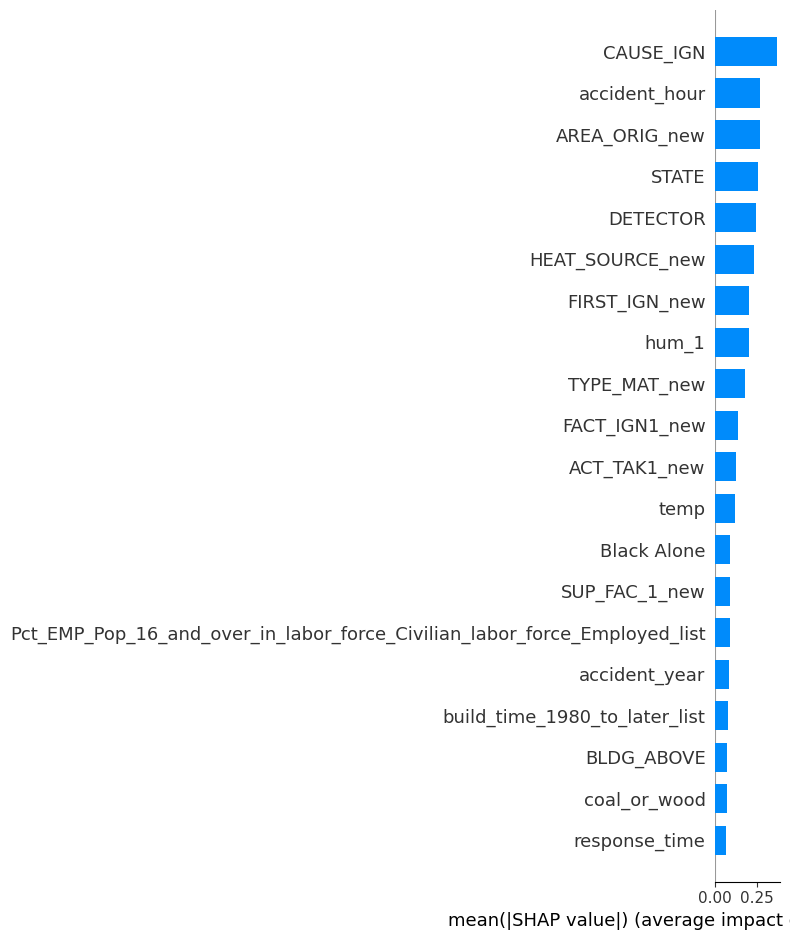

In [21]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values[:,:,0], X_test,plot_type='bar')

In [ ]:
joblib.dump(model, os.path.join(step2_injury_results_path, 'model_cont_inj_cat_best_gpu_city_v1.pkl'))
X_test.to_pickle(os.path.join(step2_injury_results_path, 'X_test_inj_cat_best_gpu_city_v1.pkl'))
y_test.to_pickle(os.path.join(step2_injury_results_path, 'y_test_inj_cat_best_gpu_city_v1.pkl'))
X_train.to_pickle(os.path.join(step2_injury_results_path, 'x_train_inj_cat_best_gpu_city_v1.pkl'))
y_train.to_pickle(os.path.join(step2_injury_results_path, 'y_train_inj_cat_best_gpu_city_v1.pkl'))

joblib.dump(shap_values, os.path.join(step2_injury_results_path, 'shap_values_inj_cat_best_gpu_city_v1.pkl'))
probs = model.predict_proba(X_test)
joblib.dump(probs, os.path.join(step2_injury_results_path, 'y_prob_inj_cat_best_gpu_city_v1.pkl'))

## mark: in V7, i deleted all the fires that are too small (det_operate=1) or implies that fire is ignited by other fire df=df[df['CAUSE_IGN']!='0'],df.drop(columns=['DET_OPERAT'],inplace=True),df=df[df['HEAT_SOURCE_new']!='8']


['/content/gdrive/Othercomputers/My Computer/Fire_risk_main/data/hongru_share//step_2/injury_severity/results/y_prob_inj_cat_best_gpu_city_v1.pkl']